## Multiple Parameter Estimations
A single optimization problem run many times can reveal more information that running just the once. Pycotools is geared towards running and analysing multiple parameter estimations

In [1]:
%matplotlib inline
import site, os, glob, pandas
site.addsitedir(r'C:/Users/Ciaran/Documents/pycotools')
from pycotools import model, tasks, viz, misc

C:\Users\Ciaran\Documents\pycotools\pycotools\viz.py:117: FutureWarning: The pandas.parser module is deprecated and will be removed in a future version. Please import from the pandas.io.parser instead
  from pandas.parser import CParserError


### Build Example Model
Here we use the same model as in the QuickStart tutorial.

In [2]:
working_directory = r'C:\Users\Ciaran\Documents\PycotoolsQuickStart'
copasi_file = os.path.join(working_directory, 'quick_start_model.cps')

if os.path.isfile(copasi_file):
    os.remove(copasi_file)

    
kf = 0.01
kb = 0.1
kcat = 0.05
with model.Build(copasi_file) as m:
    m.name = 'Michaelis-Menten'
    m.add('compartment', name='Cell')
    
    m.add('metabolite', name='P', concentration=0)
    m.add('metabolite', name='S', concentration=30)
    m.add('metabolite', name='E', concentration=10)
    m.add('metabolite', name='ES', concentration=0)
    
    m.add('reaction', name='S bind E', expression='S + E -> ES', rate_law='kf*S*E',
          parameter_values={'kf': kf})
    
    m.add('reaction', name='S unbind E', expression='ES -> S + E', rate_law='kb*ES',
         parameter_values={'kb': kb})

    m.add('reaction', name='ES produce P', expression='ES -> P + E', rate_law='kcat*ES', 
          parameter_values={'kcat': kcat})
    
michaelis_menten = model.Model(copasi_file)
michaelis_menten

Model(name=Michaelis-Menten, time_unit=s, volume_unit=ml, quantity_unit=mmol)

### Simulate Time Course

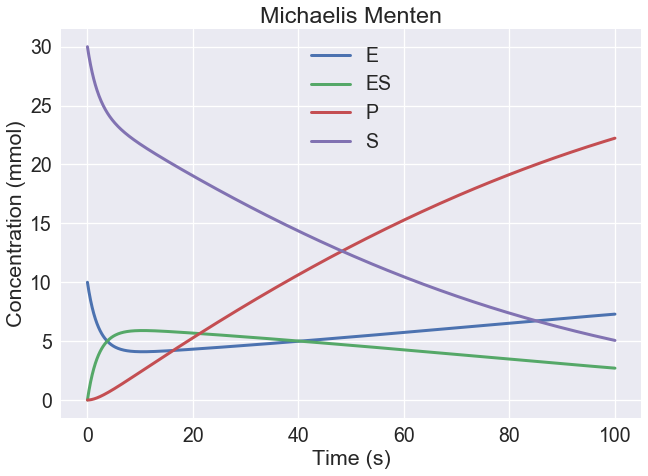

In [3]:
tc = tasks.TimeCourse(michaelis_menten, end=100, intervals=100, step_size=0.1)
viz.PlotTimeCourse(tc, separate=False, title='Michaelis Menten')

### Generate Synthetic Data

In [4]:
report= 'parameter_estimation_synthetic_data.txt'
TC=tasks.TimeCourse(
    michaelis_menten, start=0, end=100, intervals=10, step_size=10, report_name=report
)

pandas.read_csv(TC.report_name,sep='\t').head()

,Time,[E],[ES],[P],[S]
0,0,10.00000,0.00000,0.00000,30.0000
1,10,4.10191,5.89809,2.37588,21.7260
2,20,4.31725,5.68275,5.28367,19.0336
3,30,4.64091,5.35909,8.04533,16.5956
4,40,4.98869,5.01131,10.63880,14.3499


#### Format synthetic data
Copasi by default outputs outputs specie headers which do not exactly correspond to model components. Pycotools `misc.correct_copasi_output

In [5]:
misc.correct_copasi_timecourse_headers(TC.report_name)

,Time,E,ES,P,S
0,0,10.00000,0.00000,0.00000,30.00000
1,10,4.10191,5.89809,2.37588,21.72600
2,20,4.31725,5.68275,5.28367,19.03360
3,30,4.64091,5.35909,8.04533,16.59560
4,40,4.98869,5.01131,10.63880,14.34990
5,50,5.35620,4.64380,13.05330,12.30290
6,60,5.73910,4.26090,15.28000,10.45910
7,70,6.13163,3.86837,17.31260,8.81900
8,80,6.52677,3.47323,19.14800,7.37878
9,90,6.91678,3.08322,20.78670,6.13005


### Run many parameter estimations
Here we opt to estimate everything.

In [6]:
fit1=tasks.MultiParameterEstimation(
    michaelis_menten, TC.report_name, copy_number=5, pe_number=15, 
    lower_bound=1e-3, upper_bound=5e3, 
    results_directory='fit1',
    method='genetic_algorithm_sr', population_size=150, number_of_generations=300,
    overwrite_config_file=True
)
    
fit1.write_config_file()
fit1.setup()
# fit1.run()

    Time         E       ES         P         S
0      0  10.00000  0.00000   0.00000  30.00000
1     10   4.10191  5.89809   2.37588  21.72600
2     20   4.31725  5.68275   5.28367  19.03360
3     30   4.64091  5.35909   8.04533  16.59560
4     40   4.98869  5.01131  10.63880  14.34990
5     50   5.35620  4.64380  13.05330  12.30290
6     60   5.73910  4.26090  15.28000  10.45910
7     70   6.13163  3.86837  17.31260   8.81900
8     80   6.52677  3.47323  19.14800   7.37878
9     90   6.91678  3.08322  20.78670   6.13005
10   100   7.29386  2.70614  22.23340   5.06049


{0: Model(name=Michaelis-Menten, time_unit=s, volume_unit=ml, quantity_unit=mmol),
 1: Model(name=Michaelis-Menten, time_unit=s, volume_unit=ml, quantity_unit=mmol),
 2: Model(name=Michaelis-Menten, time_unit=s, volume_unit=ml, quantity_unit=mmol),
 3: Model(name=Michaelis-Menten, time_unit=s, volume_unit=ml, quantity_unit=mmol),
 4: Model(name=Michaelis-Menten, time_unit=s, volume_unit=ml, quantity_unit=mmol)}

### Boxplots

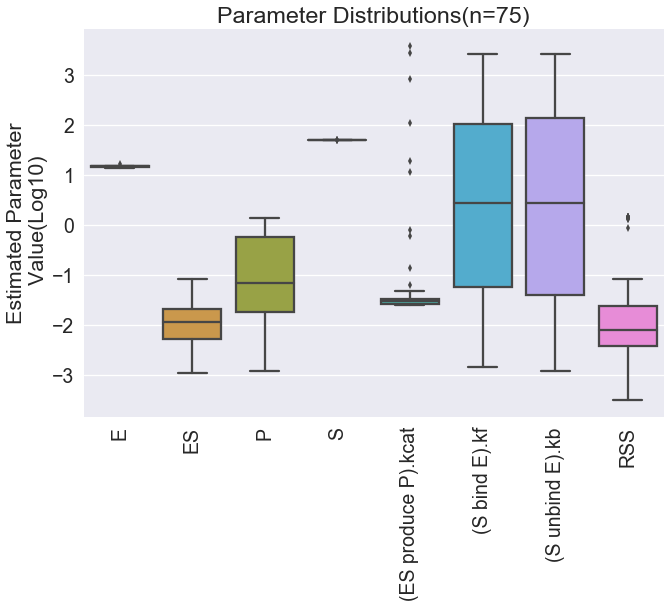

In [7]:
viz.Boxplots(fit1, num_per_plot=8, log10=True)

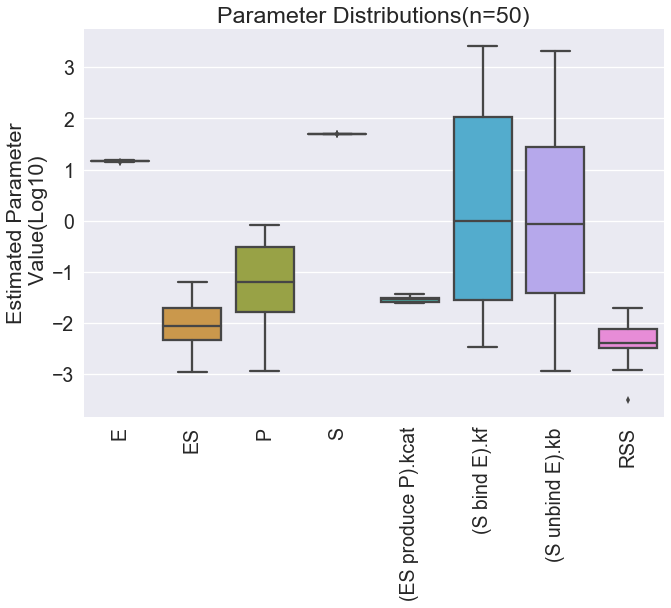

In [8]:
viz.Boxplots(fit1, num_per_plot=8, log10=True, truncate_mode='ranks', theta=range(50))

### Likelihood Ranks plot

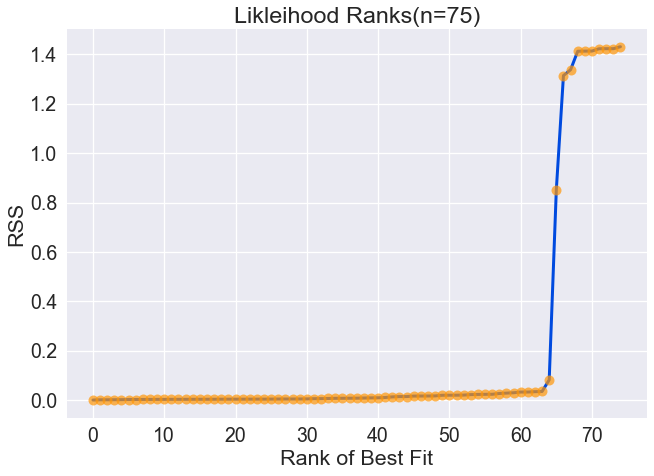

In [9]:
viz.LikelihoodRanks(fit1)

### scatters

pycotools.viz:INFO:2432:    Plotting "S" Vs "E"


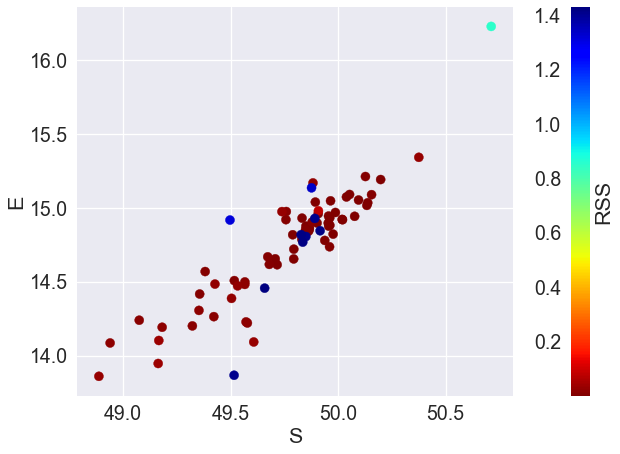

In [ ]:
viz.Scatters(fit1, x='S', y='E')

### Time course Ensemble

In [ ]:
viz.PlotTimeCourseEnsemble(fit1, truncate_mode='ranks', theta=range(10))

pycotools.viz:DEBUG:1302:    {'C:\\Users\\Ciaran\\Documents\\PycotoolsQuickStart\\parameter_estimation_synthetic_data.txt': 0       0
1      10
2      20
3      30
4      40
5      50
6      60
7      70
8      80
9      90
10    100
Name: Time, dtype: int64}


### Run Local Chaser Estimation
The Hooke and Jeeves method is deterministic and should produce the same result on each iteration. However the MultiParameterEstimation class puts the results in a folder that can be passed as argument to ProfileLikelihood. 

In [ ]:
michaelis_menten.insert_parameters(parameter_path=fit1.results_directory, index=0)
fit1_2 = tasks.MultiParameterEstimation(michaelis_menten, TC.report_name, method='hooke_jeeves', 
                                      tolerance=1e-10, iteration_limit=300, 
                                      randomize_start_values=False, overwrite_config_file=True, 
                                      lower_bound=1e-3, upper_bound=5e3, 
                                      copy_number=2, pe_number=5, results_directory='chaser_estimations')

fit1_2.write_config_file()
fit1_2.setup()
# fit1_2.run()

### Profile Likelihoods

In [ ]:
PL = tasks.ProfileLikelihood(michaelis_menten, parameter_path=fit1_2.results_directory, 
                        log10=True, index=0, intervals=30, run='parallel', results_directory='fit1_profile_likelihoods',
                        max_active=2)

#### Plot  Profile Likelihoods

pycotools.viz:INFO:3415:    saved to --> C:\Users\Ciaran\Documents\PycotoolsQuickStart\fit1_profile_likelihoods\0\(ES produce P).kcat\RSS.png
pycotools.viz:INFO:3415:    saved to --> C:\Users\Ciaran\Documents\PycotoolsQuickStart\fit1_profile_likelihoods\0\(S bind E).kf\RSS.png
pycotools.viz:INFO:3415:    saved to --> C:\Users\Ciaran\Documents\PycotoolsQuickStart\fit1_profile_likelihoods\0\(S unbind E).kb\RSS.png
pycotools.viz:INFO:3415:    saved to --> C:\Users\Ciaran\Documents\PycotoolsQuickStart\fit1_profile_likelihoods\0\E\RSS.png
pycotools.viz:INFO:3415:    saved to --> C:\Users\Ciaran\Documents\PycotoolsQuickStart\fit1_profile_likelihoods\0\ES\RSS.png
pycotools.viz:INFO:3415:    saved to --> C:\Users\Ciaran\Documents\PycotoolsQuickStart\fit1_profile_likelihoods\0\P\RSS.png
pycotools.viz:INFO:3415:    saved to --> C:\Users\Ciaran\Documents\PycotoolsQuickStart\fit1_profile_likelihoods\0\S\RSS.png


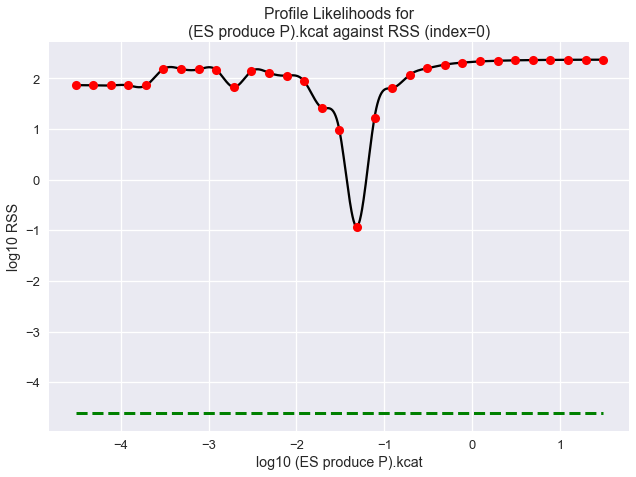

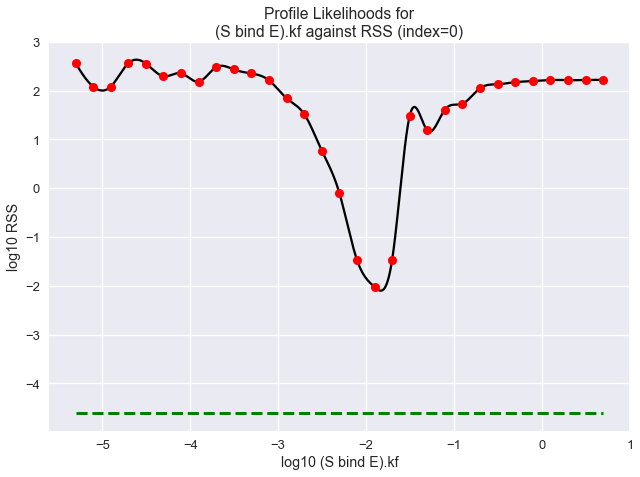

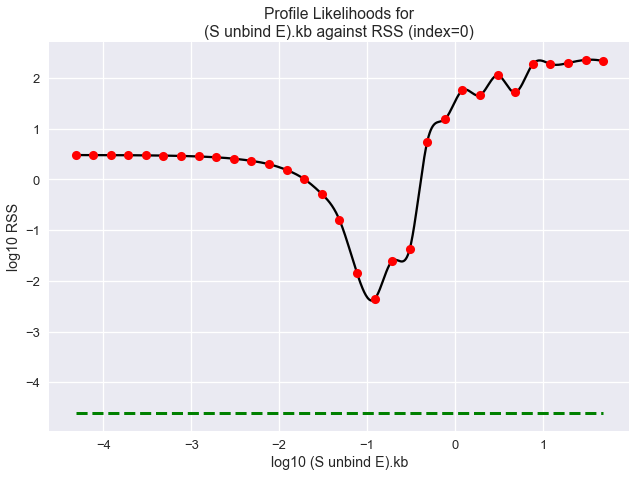

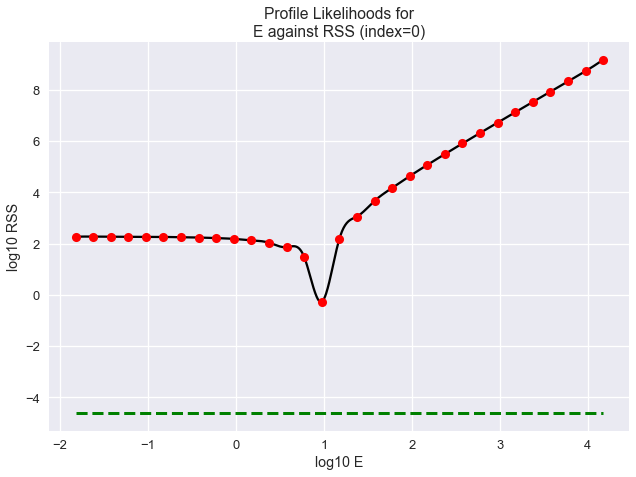

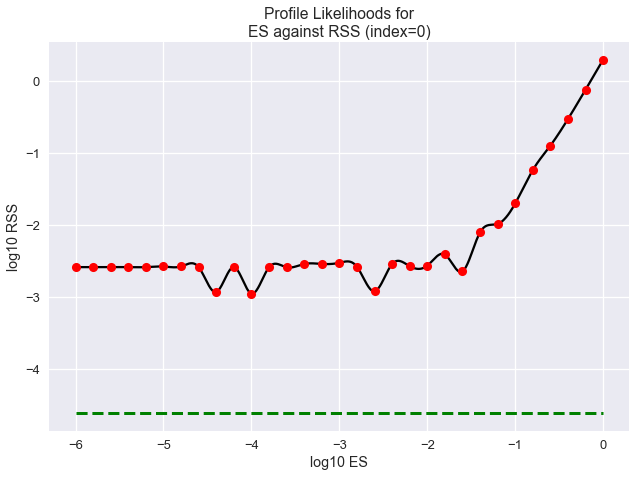

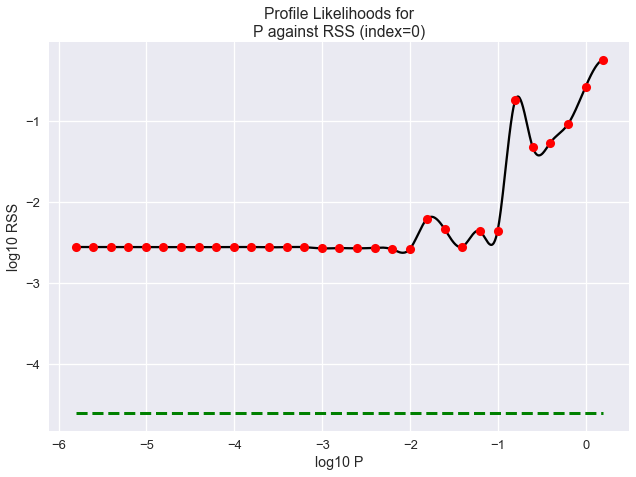

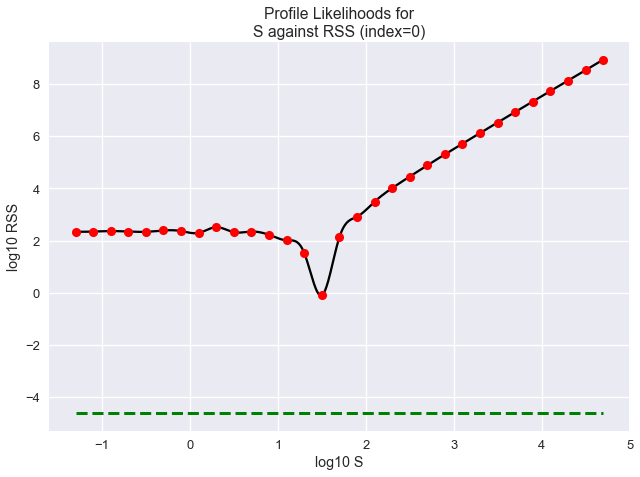

In [15]:
viz.PlotProfileLikelihood(PL, interpolation='cubic', savefig=True)

pycotools.viz:INFO:3298:    saved to --> C:\Users\Ciaran\Documents\PycotoolsQuickStart\fit1_profile_likelihoods\0\E\(ES_produce_P).kcat.png
pycotools.viz:INFO:3298:    saved to --> C:\Users\Ciaran\Documents\PycotoolsQuickStart\fit1_profile_likelihoods\0\E\(S_bind_E).kf.png
pycotools.viz:INFO:3298:    saved to --> C:\Users\Ciaran\Documents\PycotoolsQuickStart\fit1_profile_likelihoods\0\E\(S_unbind_E).kb.png
pycotools.viz:INFO:3298:    saved to --> C:\Users\Ciaran\Documents\PycotoolsQuickStart\fit1_profile_likelihoods\0\E\E.png
pycotools.viz:INFO:3298:    saved to --> C:\Users\Ciaran\Documents\PycotoolsQuickStart\fit1_profile_likelihoods\0\E\ES.png
pycotools.viz:INFO:3298:    saved to --> C:\Users\Ciaran\Documents\PycotoolsQuickStart\fit1_profile_likelihoods\0\E\P.png
pycotools.viz:INFO:3298:    saved to --> C:\Users\Ciaran\Documents\PycotoolsQuickStart\fit1_profile_likelihoods\0\E\RSS.png
pycotools.viz:INFO:3298:    saved to --> C:\Users\Ciaran\Documents\PycotoolsQuickStart\fit1_profile

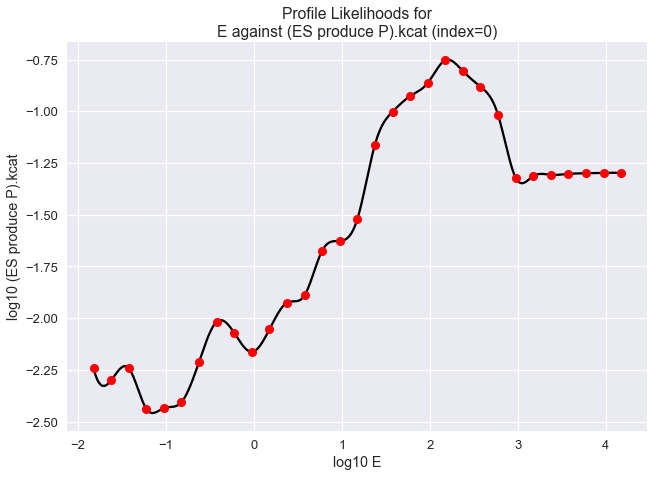

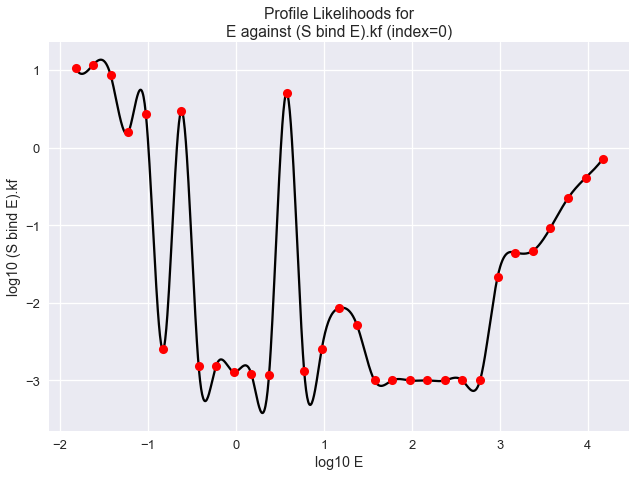

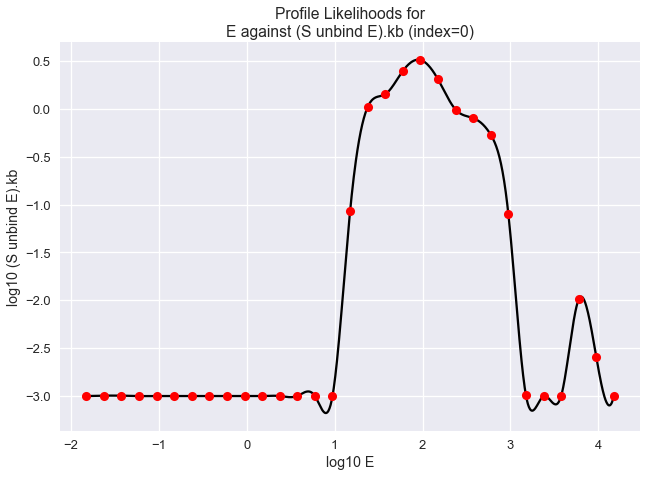

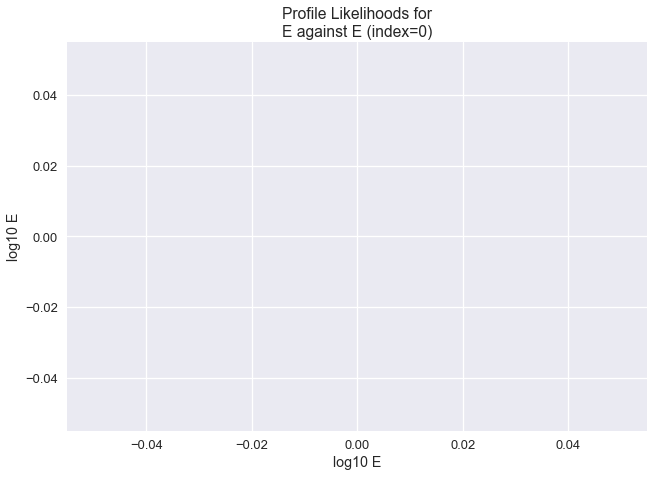

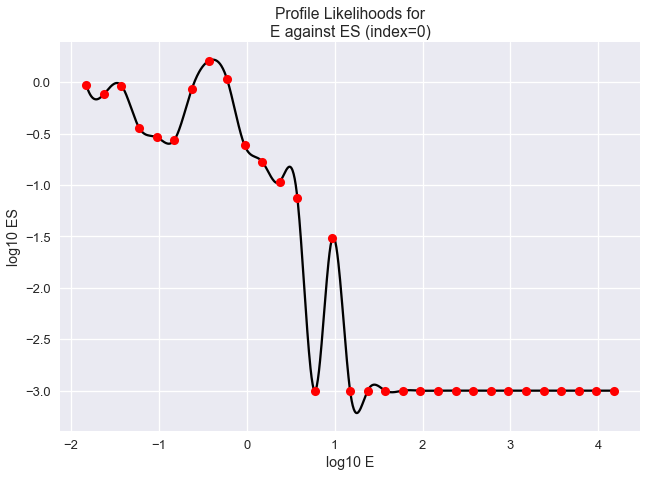

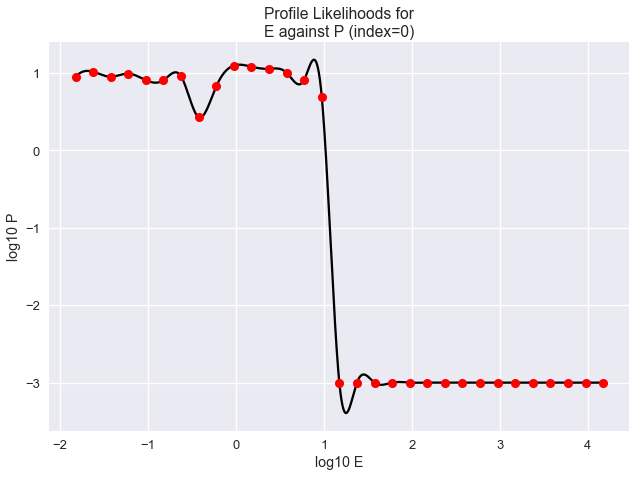

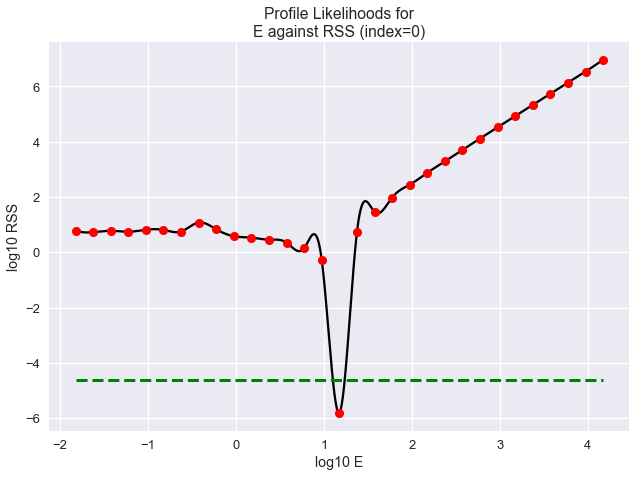

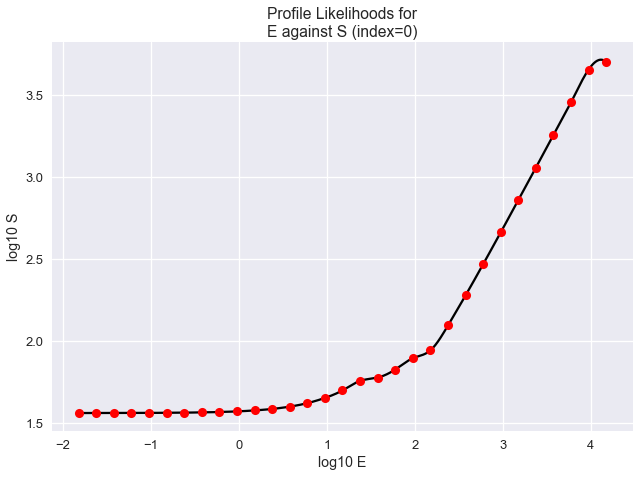

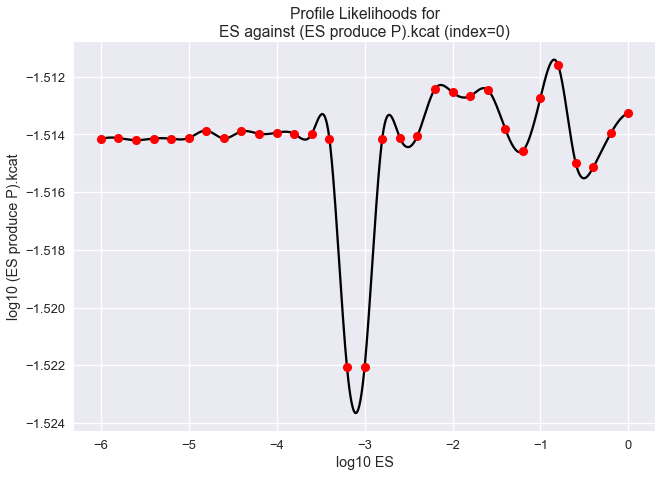

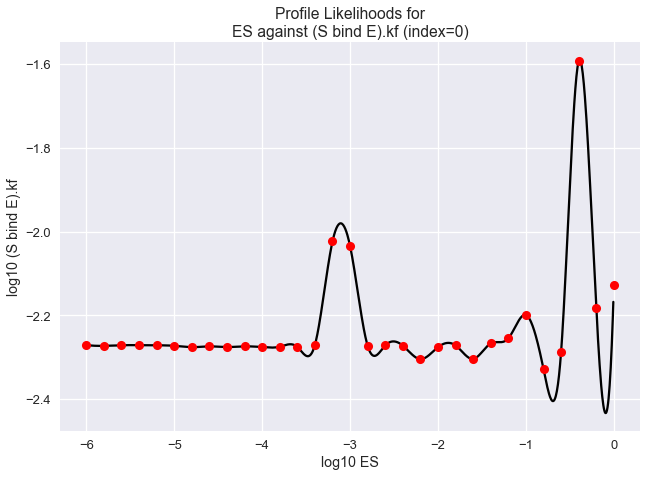

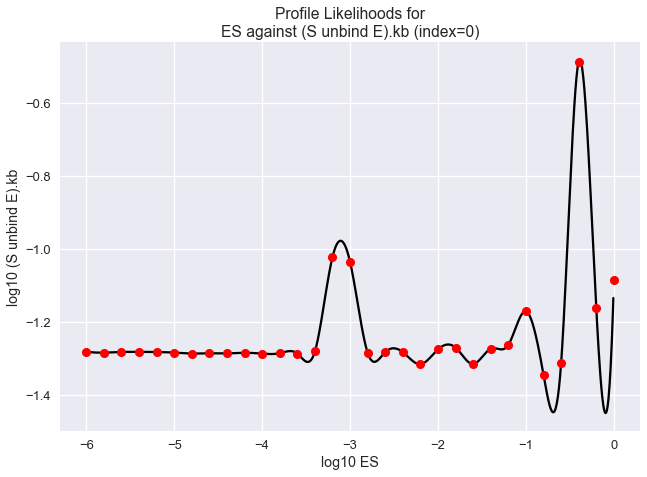

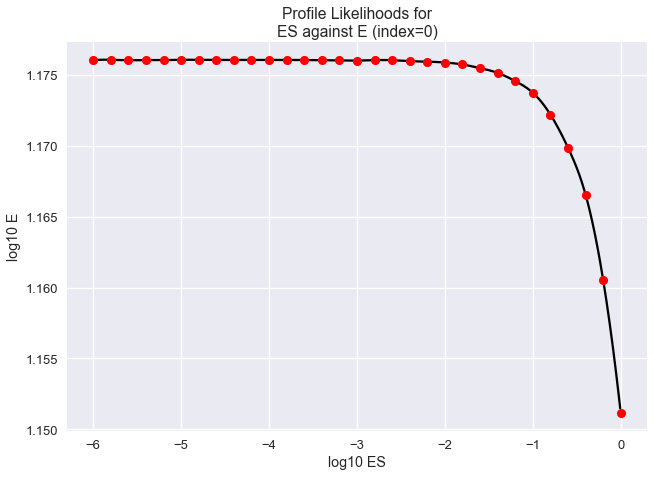

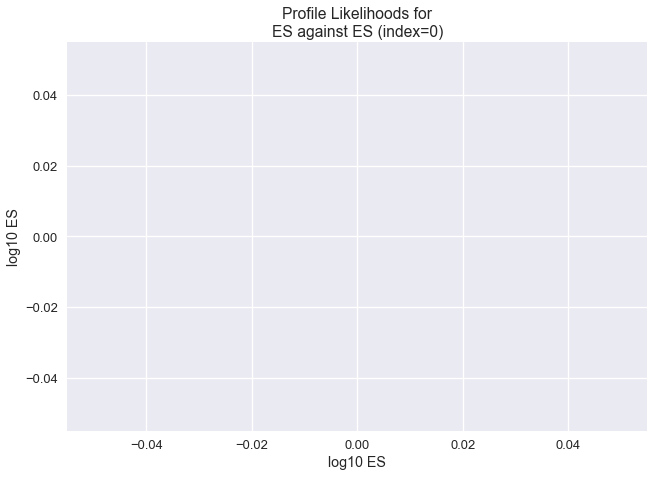

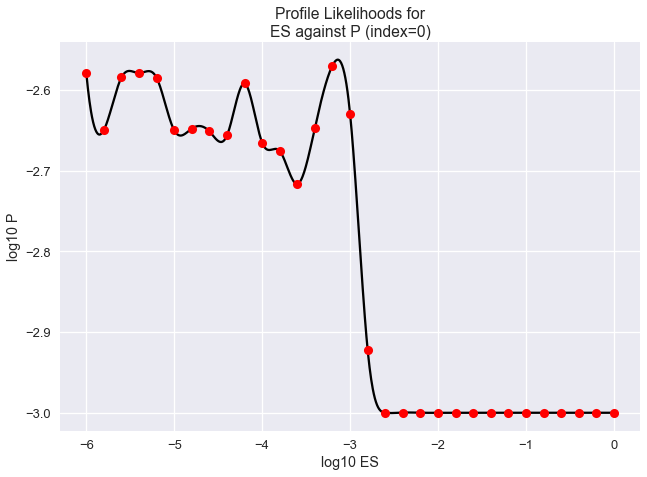

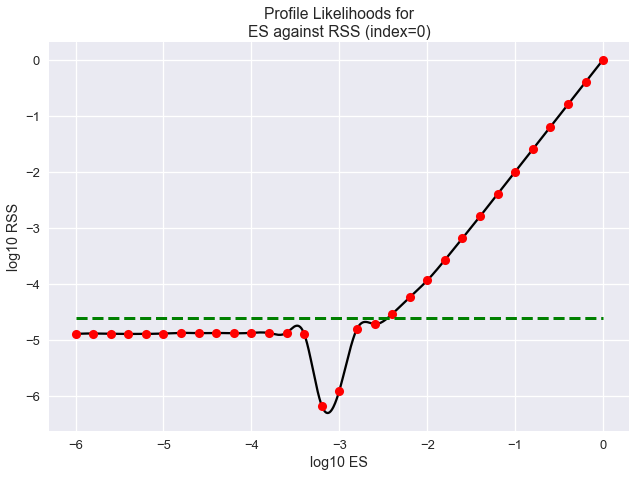

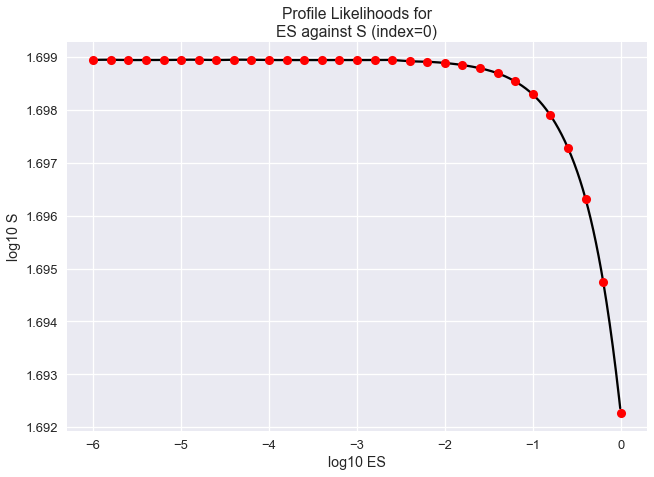

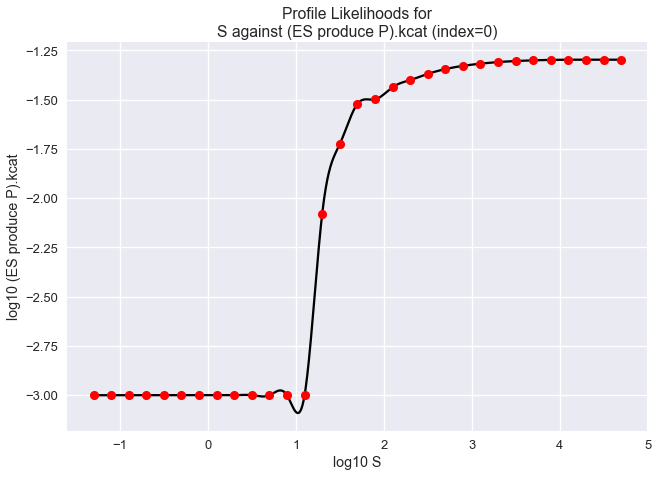

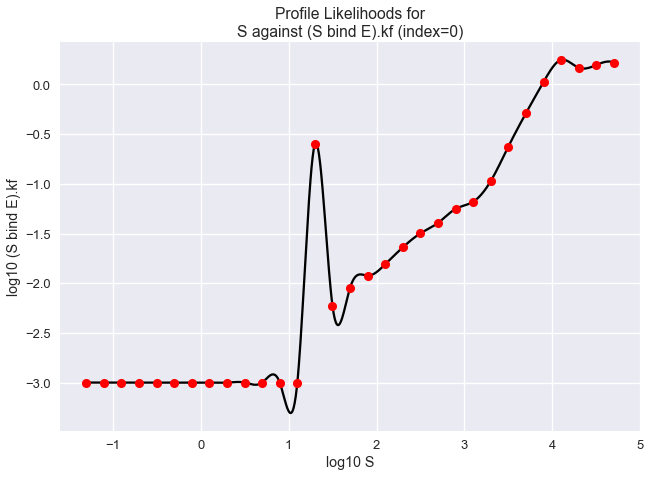

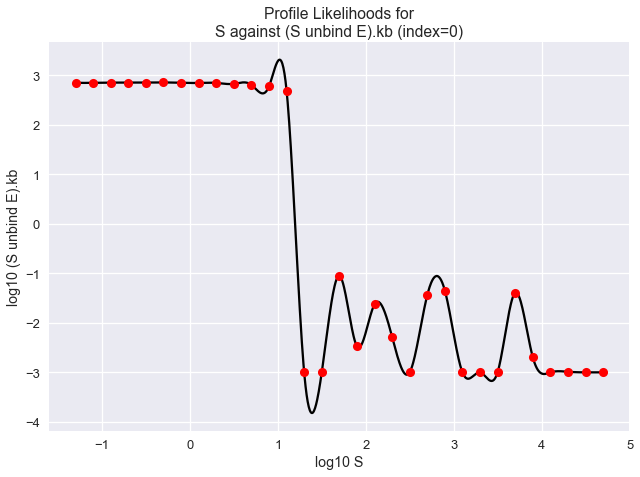

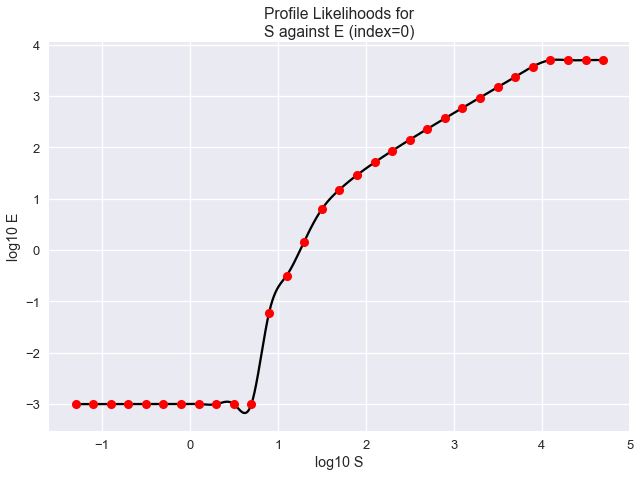

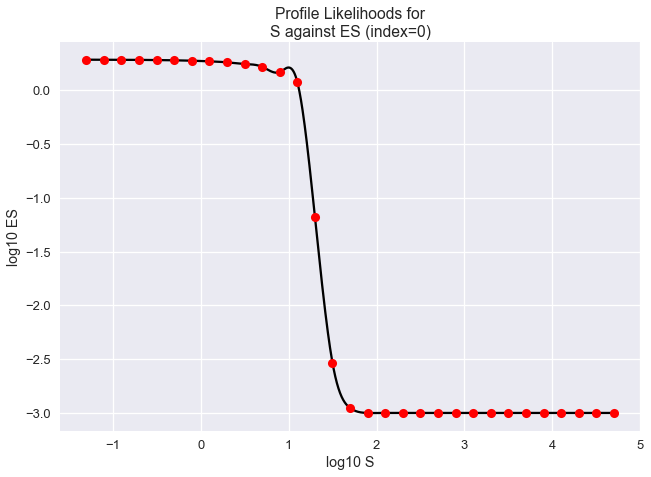

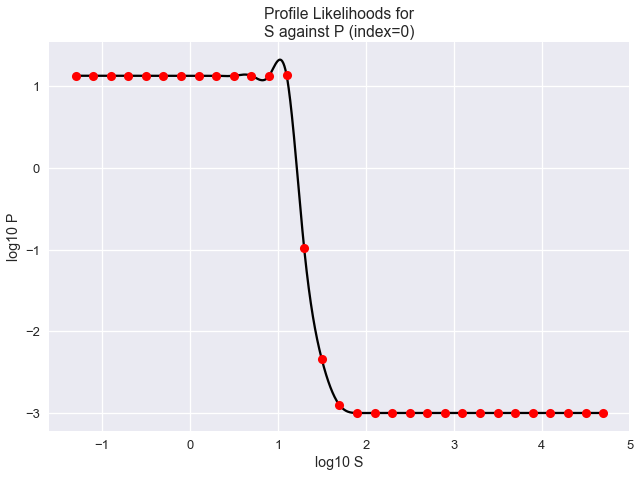

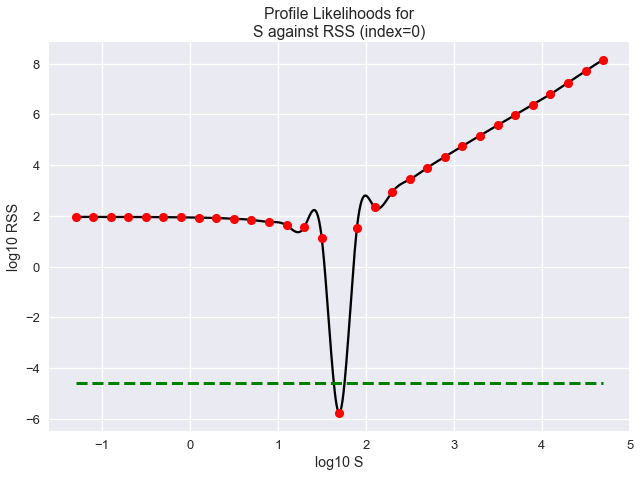

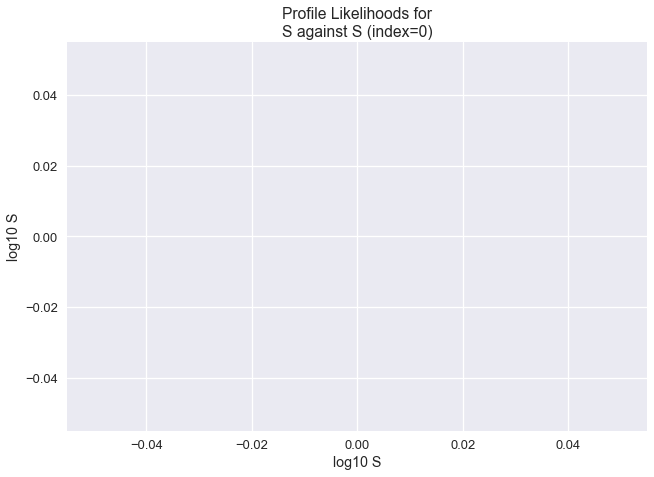

In [57]:
viz.PlotProfileLikelihood(PL, interpolation='cubic', x=['E', 'ES', 'S'], y='all', savefig=True)

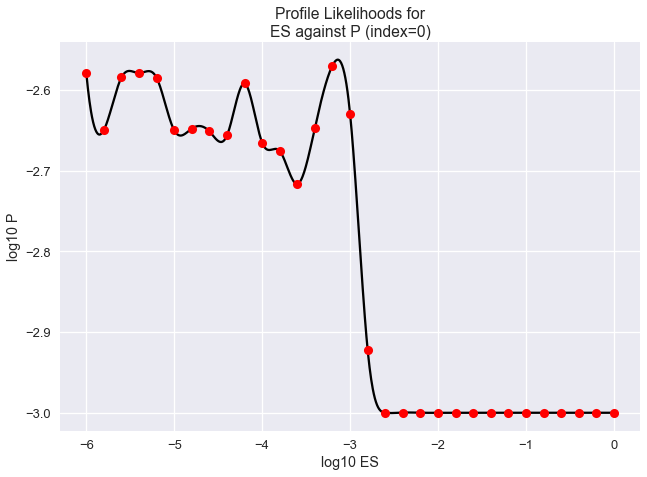

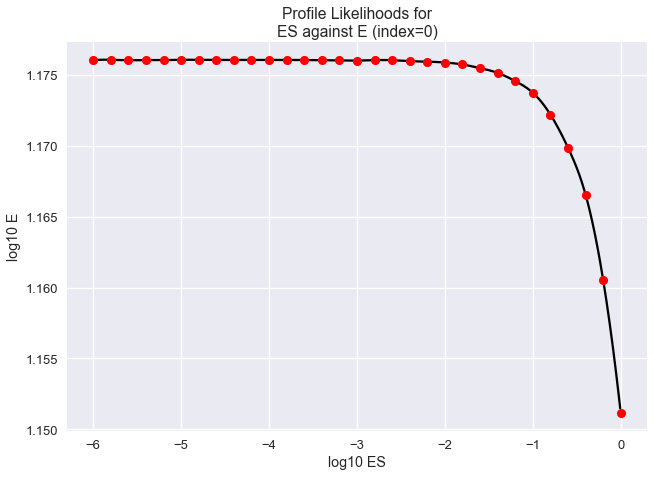

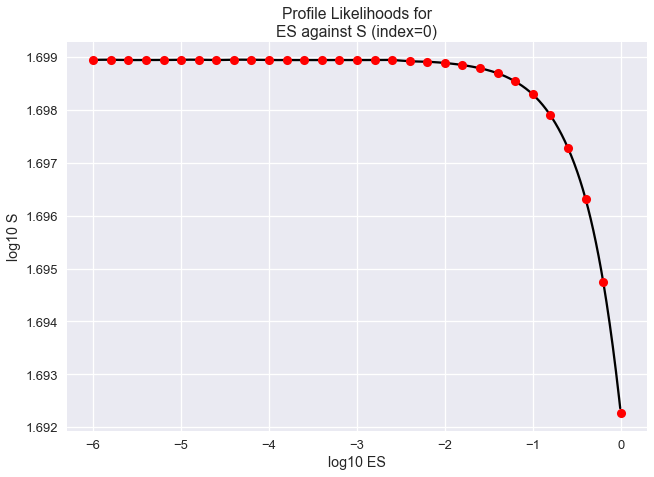

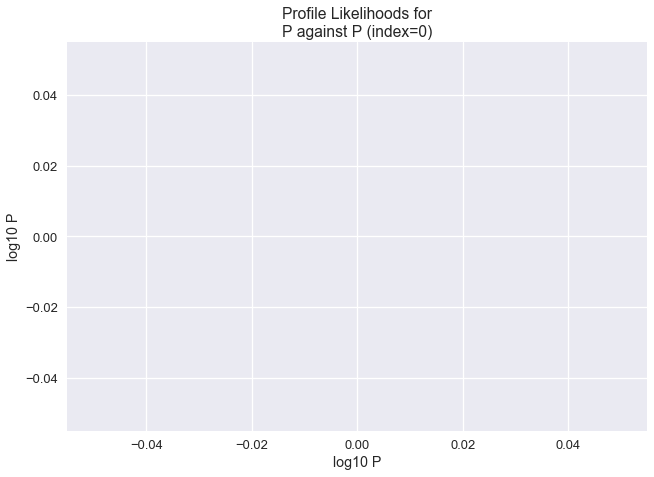

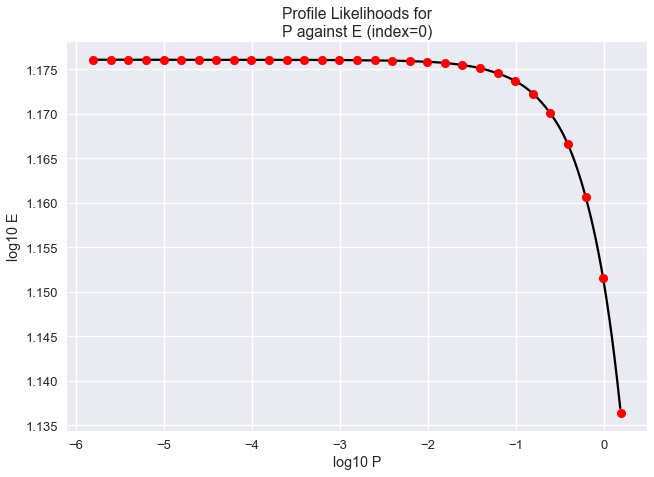

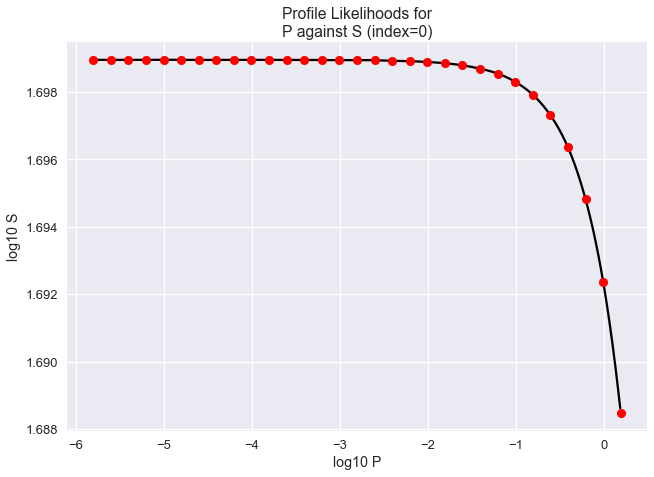

In [66]:
viz.PlotProfileLikelihood(PL, interpolation='cubic', x=['ES', 'P'], y=['P', 'E', 'S'], multiplot=True)

### Summary for Round 1
Evidence from tight parameter distributions and profile likelihood analysis suggest that E, S and kcat are identifiable parameters with tight distributions and small confidence intervals. 

ES and P appear identifiable but not at the 95% confidence level. E and S have exactly the same profile with respect to ES and P. This suggests a linear relationship between the E and S. Furthermore, Scatter graph of E versus S shows a linear correlation. Based on this it is probably possible to replace the intial concentration of either E or S with an algebraic equation in terms of the other (i.e. S0 = E * 4).  It is interesting that E and S are both identifiable with tight confidence intervals despite the apparent relationship between them. 

kf and kb look identifiable but 'messy' since there are multiple domains on which the parameters are identifable. These profiles look like the parameters have not found an optimal value with respect to the data. This is based on the fact that if you run a profile likelihood from random parameters you get a messy profile similar to these profiles. It may be that these parameters are not as sensitive and therefore harder to estimate than the others. 

For a subsequent round of estimations, fix E, S and kcat parameters and estimate the rest

### Fit2: Parameter Estimations
#### Insert Best Parameter Set

In [67]:
michaelis_menten.insert_parameters(parameter_path=fit1_2.results_directory, index=0)

#### Fix S, E and (ES produce P).kcat
This can be either done manually byopening and deleting the rows for these parameters from the config file or by giving arguments to the metabolites and local_parameters kwargs.  

In [78]:
[i.name for i in michaelis_menten.metabolites if i.name not in ['S', 'E']]
[i.global_name for i in michaelis_menten.local_parameters if i.global_name not in ['(ES produce P).kcat']]

['(S bind E).kf', '(S unbind E).kb']

In [68]:
fit2 = tasks.MultiParameterEstimation(
    michaelis_menten, TC.report_name, copy_number=3, pe_number=15, 
    lower_bound=1e-3, upper_bound=5e3, 
    method='genetic_algorithm_sr', population_size=150, number_of_generations=300,
    overwrite_config_file=True, 
    results_directory='fit2',
    metabolites=[i.name for i in michaelis_menten.metabolites if i.name not in ['S', 'E']], 
    local_parameters=[i.global_name for i in michaelis_menten.local_parameters if i.global_name not in ['(ES produce P).kcat']]
)
    
fit2.write_config_file()
fit2.setup()
#fit2.run()

### Fit2: Visualizations
#### Box plots

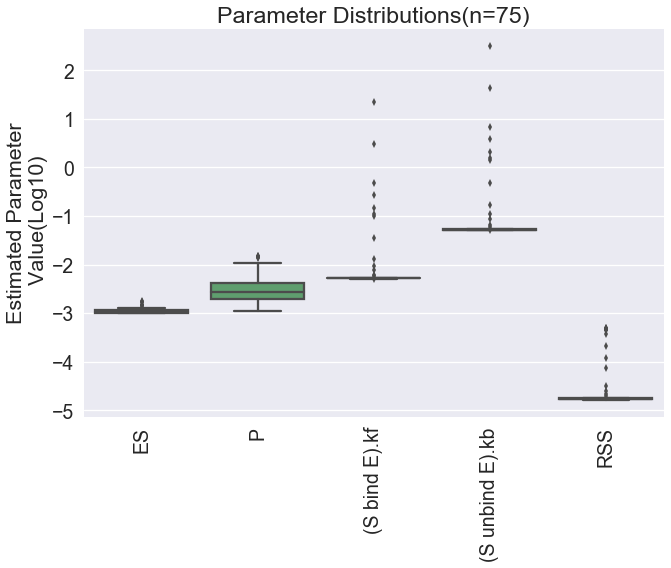

In [69]:
viz.Boxplots(fit2, log10=True)

#### Fit2: Likelihood Ranks

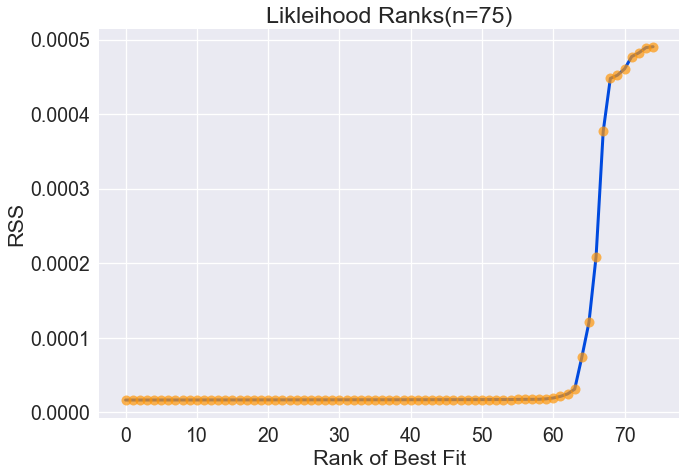

In [70]:
viz.LikelihoodRanks(fit2)

#### Fit2: Profiles
Based on likelihood-ranks plot, we visualize profiles from the top 60 parameter sets.

pycotools.viz:INFO:1353:    Plotting "E"
pycotools.viz:INFO:1353:    Plotting "ES"
pycotools.viz:INFO:1353:    Plotting "P"
pycotools.viz:INFO:1353:    Plotting "S"


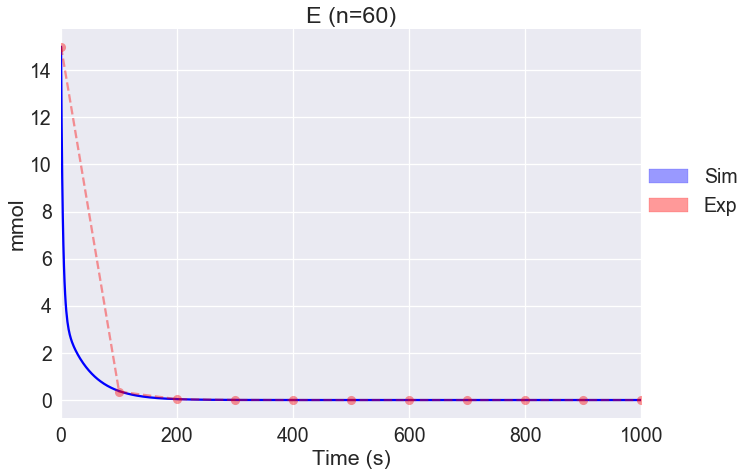

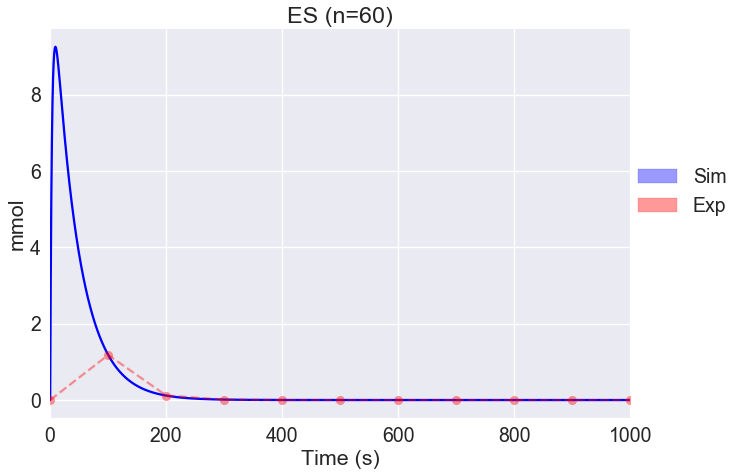

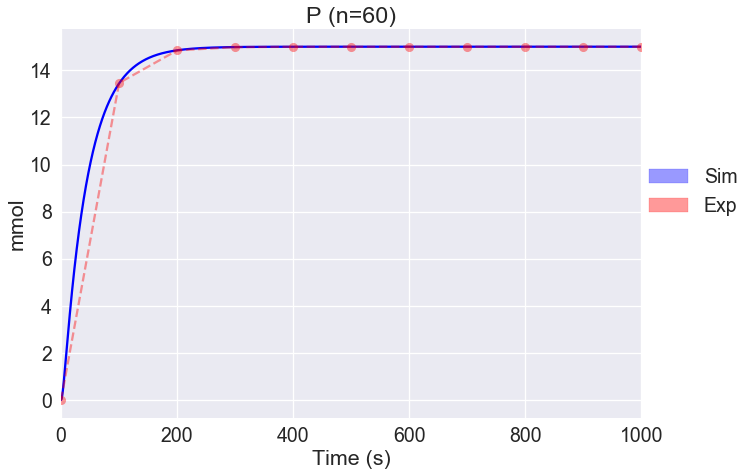

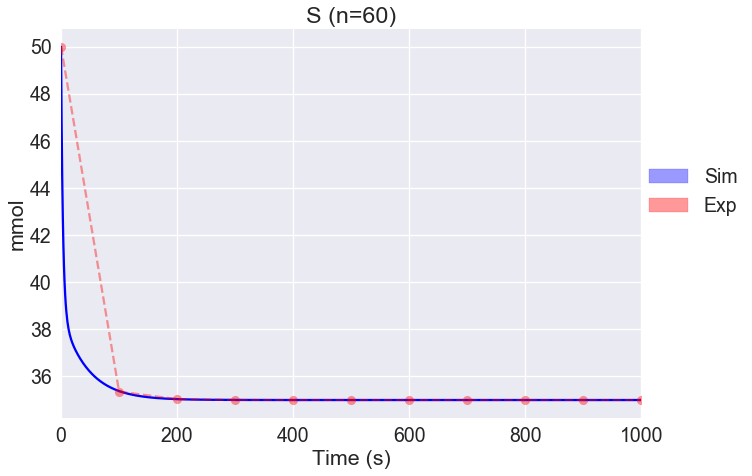

In [89]:
viz.PlotTimeCourseEnsemble(fit2, truncate_mode='ranks', theta=range(60))

### Fit2:  Profile Likelihoods

In [73]:
PL = tasks.ProfileLikelihood(michaelis_menten, parameter_path=fit2.results_directory, 
                        log10=True, index=0, intervals=30, run=True, 
                        max_active=3, results_directory='fit2_profile_likelihoods')

pycotools.tasks:INFO:4558:    running C:\Users\Ciaran\Documents\PycotoolsQuickStart\fit2_profile_likelihoods\0\P.cps
pycotools.tasks:INFO:4558:    running C:\Users\Ciaran\Documents\PycotoolsQuickStart\fit2_profile_likelihoods\0\(S_bind_E).kf.cps
pycotools.tasks:INFO:4558:    running C:\Users\Ciaran\Documents\PycotoolsQuickStart\fit2_profile_likelihoods\0\(S_unbind_E).kb.cps
pycotools.tasks:INFO:4558:    running C:\Users\Ciaran\Documents\PycotoolsQuickStart\fit2_profile_likelihoods\0\ES.cps


#### Plot second round of profile likelihoods

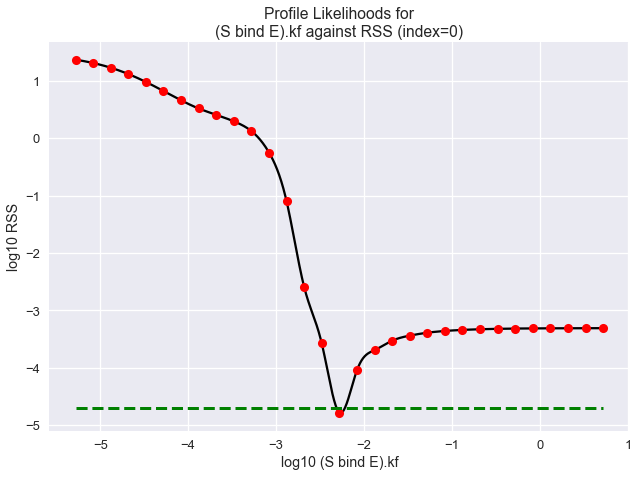

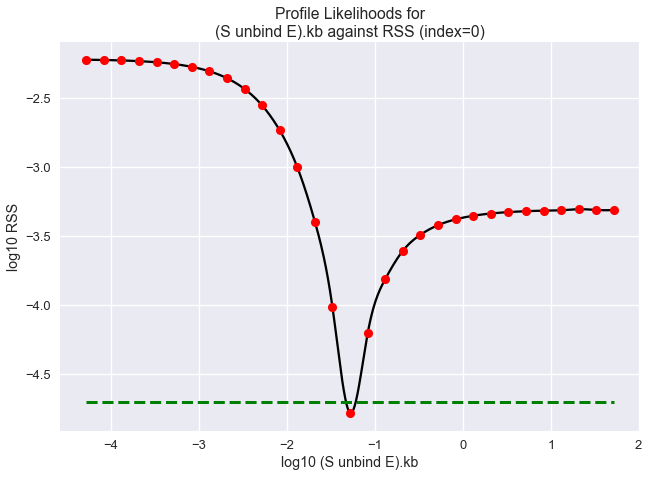

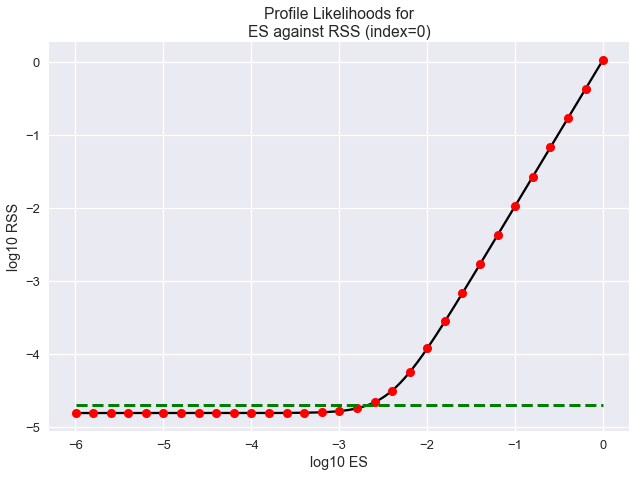

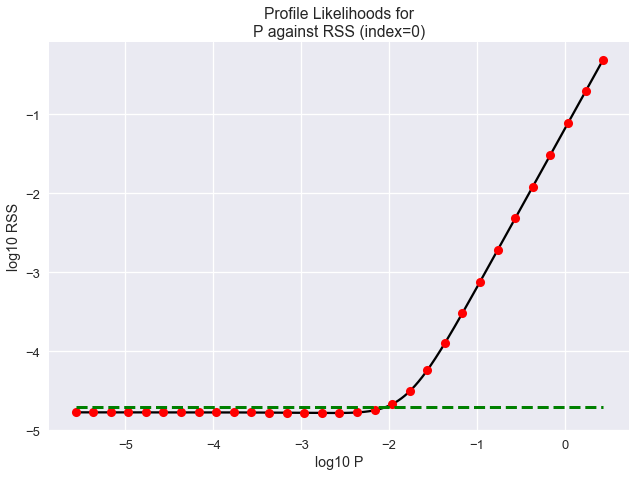

In [72]:
viz.PlotProfileLikelihood(PL, interpolation='cubic')

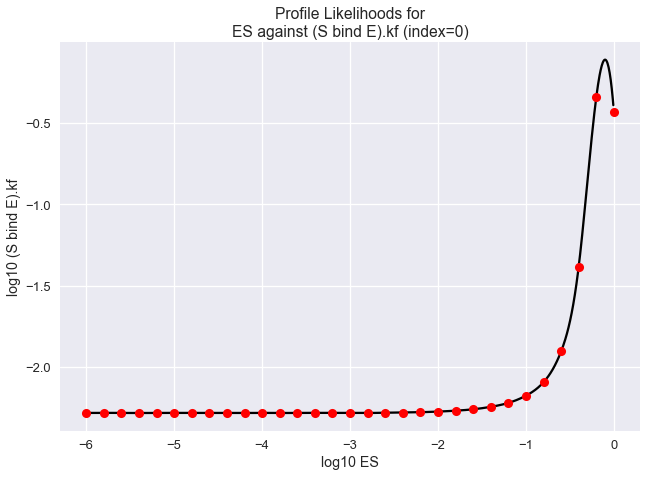

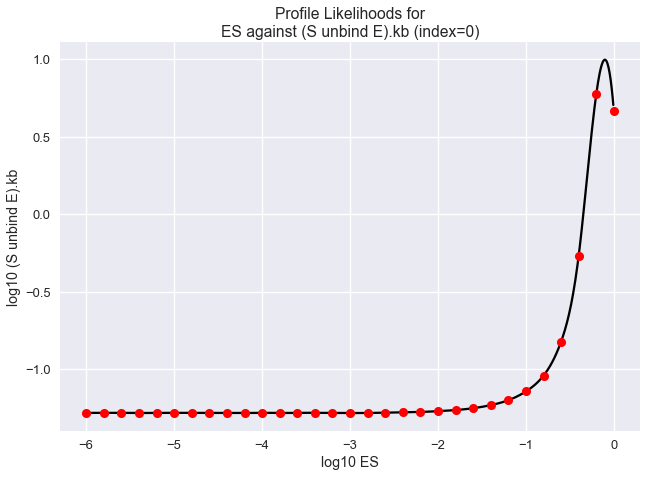

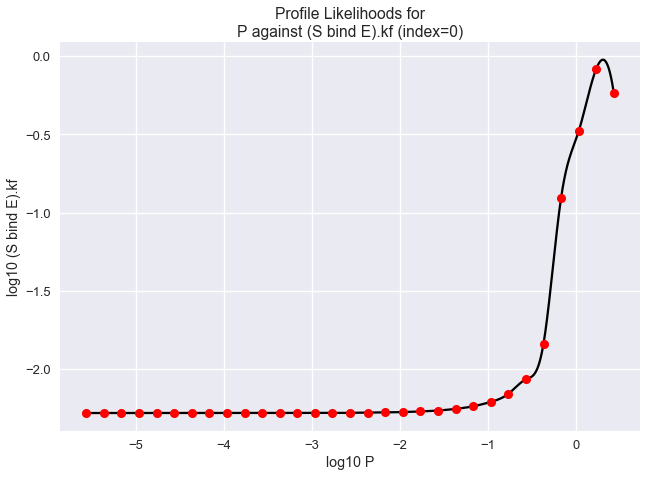

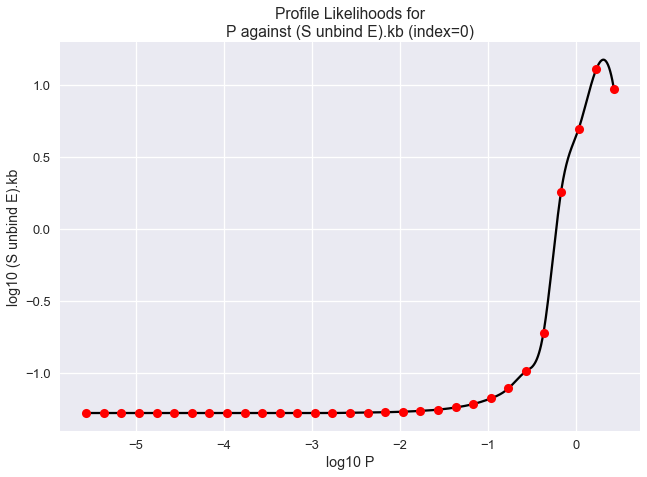

In [84]:
viz.PlotProfileLikelihood(PL, interpolation='cubic', x=['ES', 'P'],
                          y=['(S bind E).kf', '(S unbind E).kb'])

### Fit2: Summary
The kf and kb parameters are not identifiable while the initial concentrations of P and ES are practically non-identifiable. It appears the kf and kb paraemters change in exactly the same way (but off-set by a constant accross the profile) with changes in P and ES. 

Now we fix kf and kb as well as the others and see if the last two parameters become identifiable. 

### Fit3: Parameter Estimations
#### Insert Best Parameters from Fit2

In [86]:
michaelis_menten.insert_parameters(parameter_path=fit2.results_directory, index=0)

#### Run more estimations with fixed kf and kb

In [118]:
fit3 = tasks.MultiParameterEstimation(
    michaelis_menten, TC.report_name, copy_number=3, pe_number=15, 
    lower_bound=1e-3, upper_bound=5e3, 
    method='genetic_algorithm_sr', population_size=150, number_of_generations=300,
    overwrite_config_file=True, 
    results_directory='fit3',
    metabolites=[i.name for i in michaelis_menten.metabolites if i.name not in ['S', 'E']], 
    local_parameters=[i.global_name for i in michaelis_menten.local_parameters if i.global_name not in ['(ES produce P).kcat', 
                                                                                                        '(S bind E).kf',
                                                                                                        '(S unbind E).kb']]
)
    
fit3.write_config_file()
fit3.setup()
#fit3.run()

{0: Model(name=Michaelis-Menten, time_unit=s, volume_unit=ml, quantity_unit=mmol),
 1: Model(name=Michaelis-Menten, time_unit=s, volume_unit=ml, quantity_unit=mmol),
 2: Model(name=Michaelis-Menten, time_unit=s, volume_unit=ml, quantity_unit=mmol)}

### Fit3: Visualizations
#### Boxplots

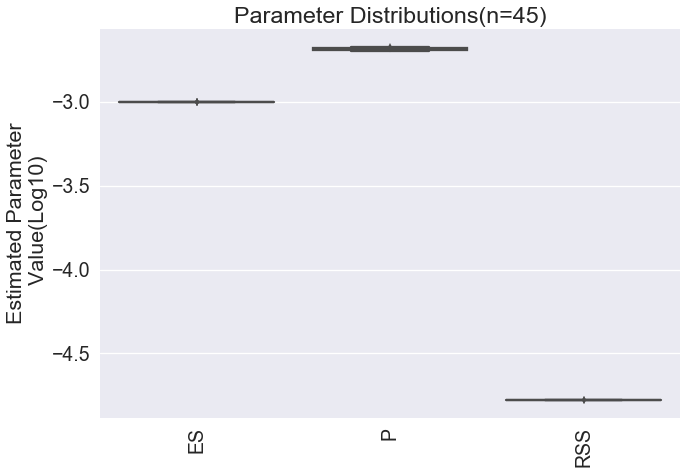

In [110]:
viz.Boxplots(fit3, log10=True)

#### Likelihood Ranks

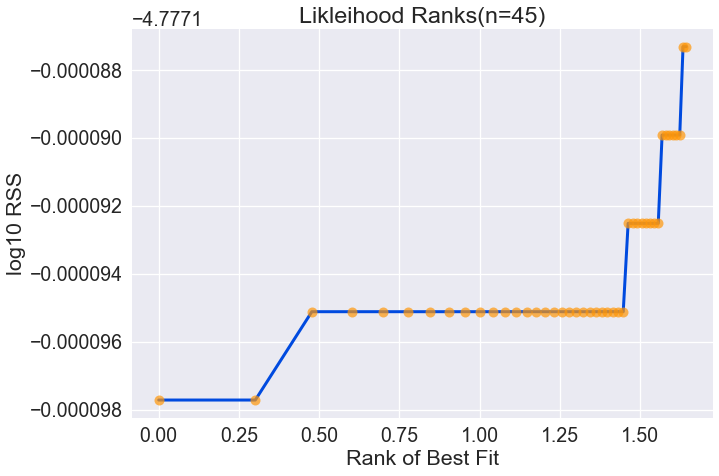

In [111]:
viz.LikelihoodRanks(fit3, log10=True)

### Fit3: Profile Likelihoods

In [114]:
PL3 = tasks.ProfileLikelihood(michaelis_menten, parameter_path=fit3.results_directory, 
                        log10=True, index=0, intervals=30, run=True, 
                        max_active=3, results_directory='fit3_profile_likelihoods')

pycotools.tasks:INFO:4558:    running C:\Users\Ciaran\Documents\PycotoolsQuickStart\fit3_profile_likelihoods\0\P.cps
pycotools.tasks:INFO:4558:    running C:\Users\Ciaran\Documents\PycotoolsQuickStart\fit3_profile_likelihoods\0\ES.cps


#### Plot Profile Likelihoods

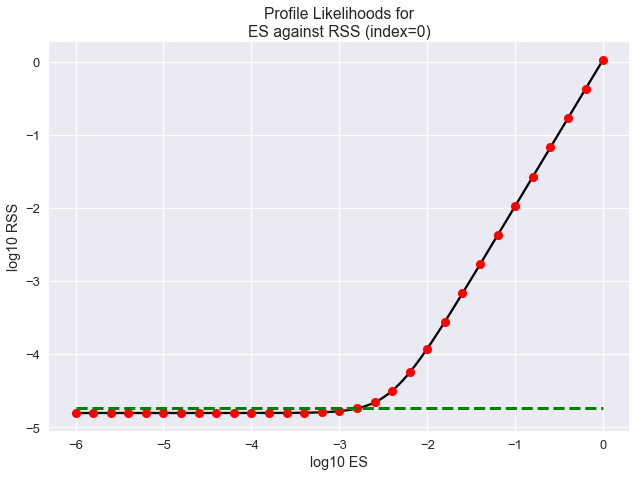

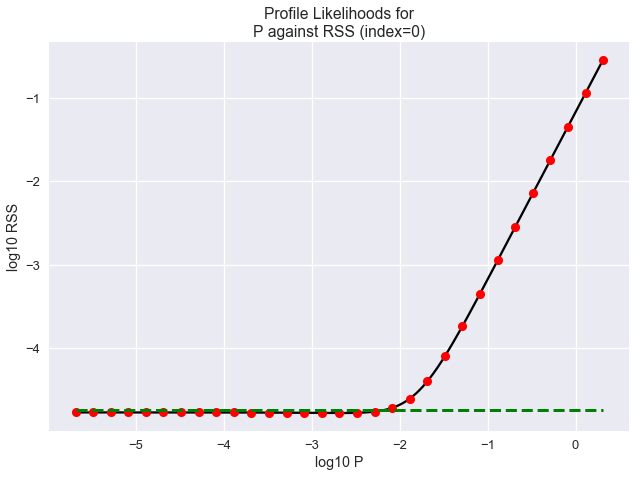

In [115]:
viz.PlotProfileLikelihood(PL3, interpolation='cubic')

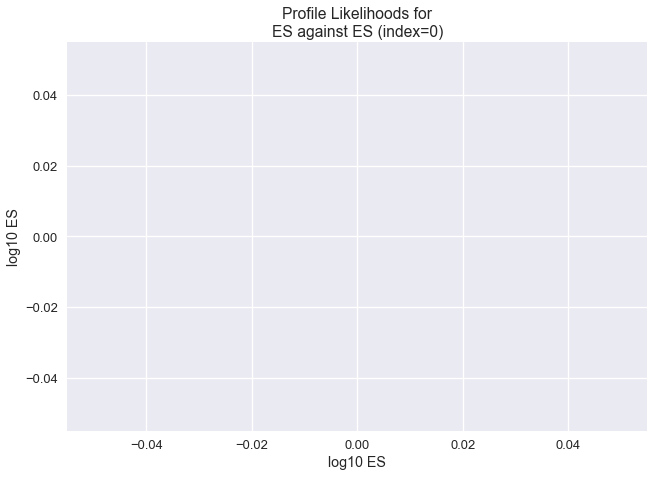

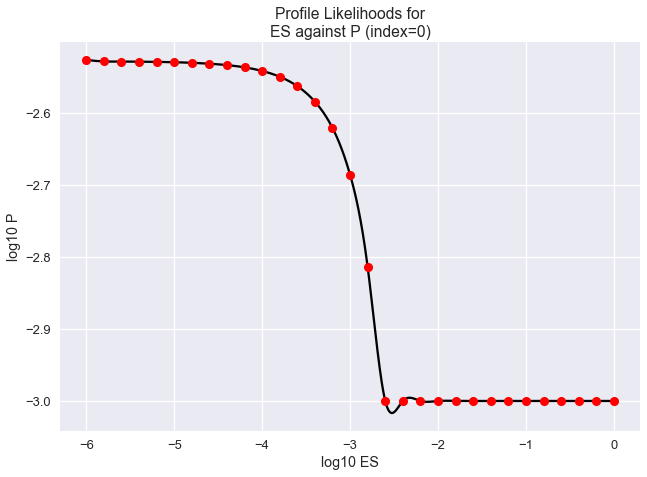

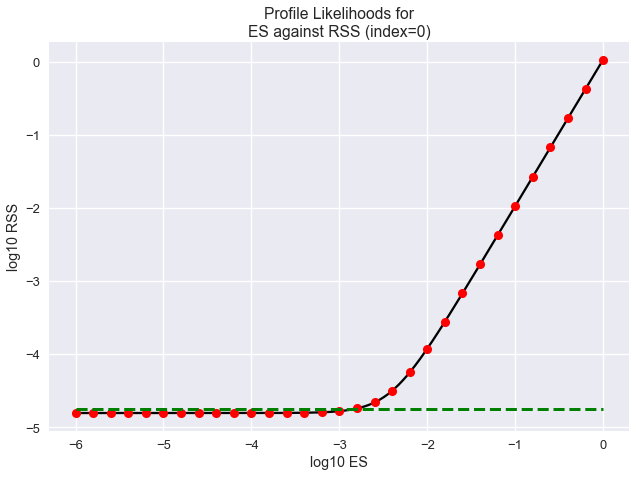

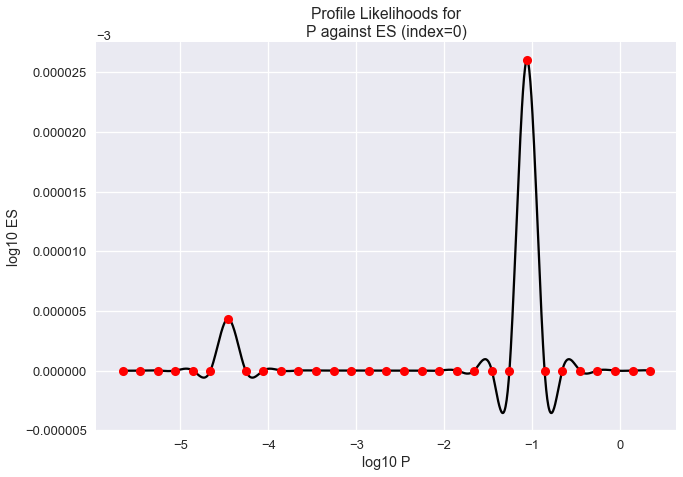

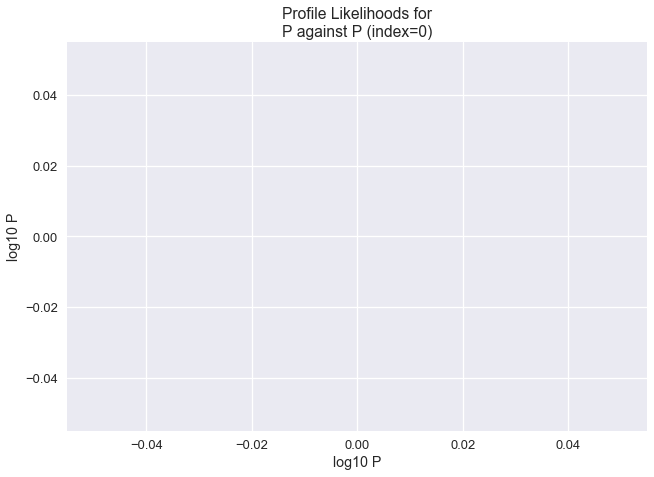

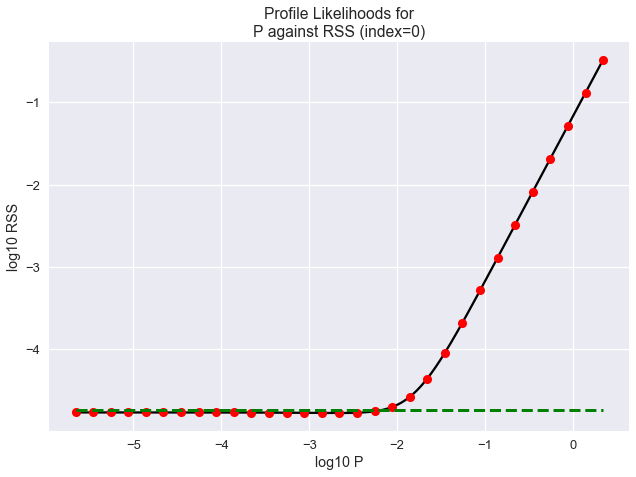

In [100]:
viz.PlotProfileLikelihood(PL3, interpolation='cubic', x=['ES', 'P'], y='all')

### Fit3 Insert Parameters

In [130]:
michaelis_menten.insert_parameters(parameter_path=fit3.results_directory, index=0)

### Fit3: Time Course

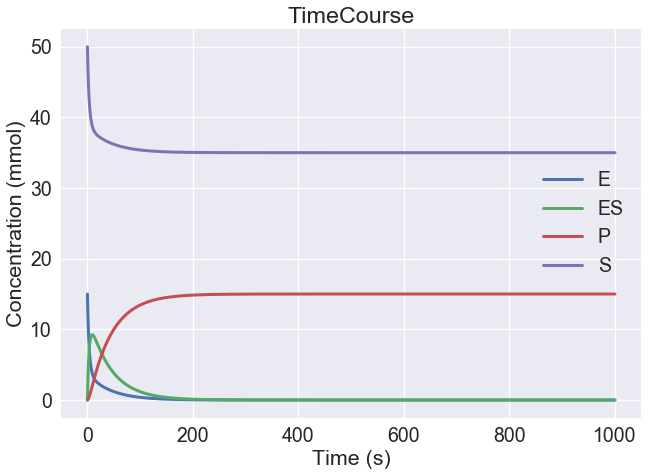

In [131]:

TC2 = tasks.TimeCourse(michaelis_menten, end=1000, step_size=1, intervals=1000)
viz.PlotTimeCourse(TC2, separate=False)

### Best parameters

In [142]:
one = viz.Parse(fit1).data.iloc[0][['E', 'S', '(ES produce P).kcat']]
two = viz.Parse(fit2).data.iloc[0][['(S bind E).kf', '(S unbind E).kb']]
three = viz.Parse(fit3).data.iloc[0][['P', 'ES']]

print(one)
print (two)
print(three)

E                      14.960500
S                      49.907600
(ES produce P).kcat     0.030215
Name: 0, dtype: float64
(S bind E).kf      0.005238
(S unbind E).kb    0.052332
Name: 0, dtype: float64
P     0.002054
ES    0.001000
Name: 0, dtype: float64


### Fit3: Summary
Despite fixing all other parameters, it appears the initial concentration of P and ES are practically non-identifiable in the decreasing direction. However, it looks as though both parameters have tight distributions accross all fits and the optimizations are performing well. 

The profiles from the third round of estimations appear not to have changed since the second round. Judging from these profiles, it looks as though the resolution at early time points is not fine enough to capture the detail in parameter estimation. 

From here we could experimentally measure (or simulate) the same profiles again but at a finer resolution and then repeat the procedure. 